## vggt

### setting up 

In [1]:
import sys, os
notebook_dir = os.getcwd()
sys.path.append(os.path.join(notebook_dir, "submodules", "vggt"))

In [2]:
import torch
from submodules.vggt.vggt.models.vggt import VGGT
from submodules.vggt.vggt.utils.load_fn import load_and_preprocess_images
from pc_inference import load_images, load_model, pc_inference

import open3d as o3d
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### usage 

In [6]:
img_folder_path = "data/leonora/ship_of_cranes/images"
model_path = "/home/sergio/checkpoints/vggt/model.pt"
# model inference 
images, ori_size, _ = load_images(path_images=img_folder_path)
model = load_model(model_path=model_path)
predictions = pc_inference(
    model=model, images=images, use_point_map=False, init_conf_threshold=50
)

num images:  7


Loading model...
Running VGGT inference...
Converting pose encoding to extrinsic and intrinsic matrices...
Processing model outputs...


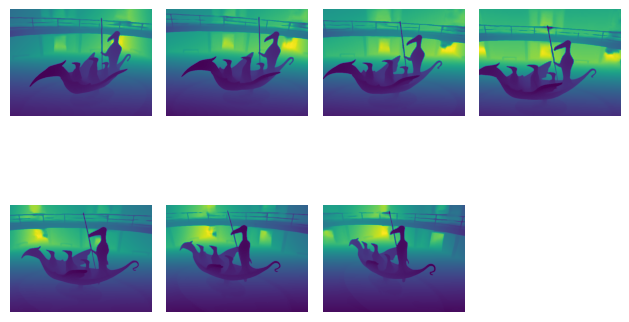

In [7]:
for i in range(images.shape[0]):
    plt.subplot(2, 4, i + 1)
    plt.imshow(predictions["depth_maps"][i])
    plt.axis("off")
    plt.tight_layout()

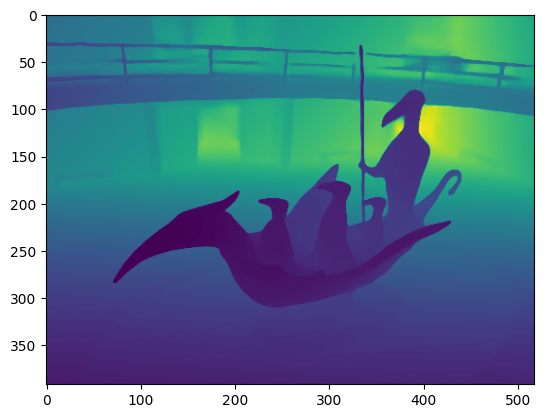

In [39]:
img = (predictions["depth_maps"][0] - predictions["depth_maps"][0].min()) / (predictions["depth_maps"][0].max() - predictions["depth_maps"][0].min())
# plt.imshow(predictions["depth_maps"][0])
plt.imshow((img * 255).astype(np.uint16))

In [42]:
import os
import numpy as np
import cv2

def save_depth_maps(depth_maps, output_folder):
    """
    Save a list of 2D NumPy arrays (depth maps) into `output_folder` as PNGs.
    """
    os.makedirs(output_folder, exist_ok=True)
    for i, dm in enumerate(depth_maps):
        # # ensure 2D
        # if dm.ndim != 2:
        #     raise ValueError(f"Depth map at index {i} is not 2D (shape={dm.shape})")
        # re-scaled 
        arr = (dm - dm.min()) / (dm.max() - dm.min())
        arr = ((arr * 255).astype(np.uint16))

        filename = f"depth_{i:06d}.png"
        out_path = os.path.join(output_folder, filename)
        # write 16-bit PNG
        if not cv2.imwrite(out_path, arr):
            raise IOError(f"Failed to write {out_path}")

    return 

save_depth_maps([predictions["depth_maps"][0]], "toy_depths")

## colmap loader 

In [39]:
from gaussian_splatting.utils.colmap import Parser, Dataset, SceneManager
import matplotlib.pyplot as plt 
from PIL import Image
import torch.nn.functional as F

In [40]:
data_dir = "data/tum/fr1_desk"
colmap_dir = "data/tum/fr1_desk/sparse/0"
data_factor = 1
test_every = 8

parser = Parser(
    data_dir=data_dir,
    factor=data_factor,
    normalize=True,
    test_every=test_every,
)

[Parser] 150 images, taken by 150 cameras.


In [41]:
dataset = Dataset(
    parser=parser, 
    split="train", 
    load_depths=True
)

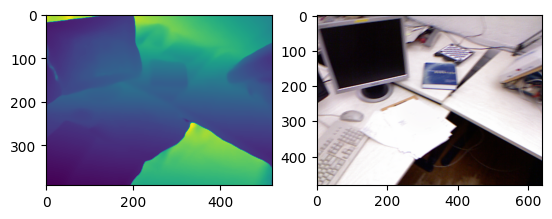

In [42]:
data = dataset[1]
plt.subplot(121); plt.imshow(data["depths"])
plt.subplot(122); plt.imshow(data["image"].to(int))

In [53]:
print(data["depths"].unsqueeze(0).unsqueeze(0).shape)
depths_gt = F.interpolate(
    data["depths"].unsqueeze(0).unsqueeze(0),
    size=(480, 640),      # (H_r, W_r)
    mode="bilinear",                      # or "bilinear" if you prefer
    align_corners=False
)

torch.Size([1, 1, 392, 518])


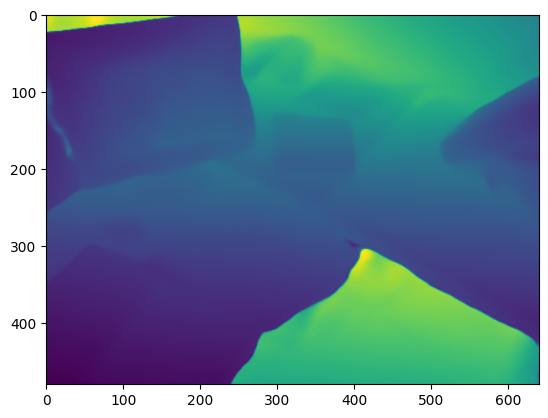

In [55]:
plt.imshow(depths_gt.squeeze())

In [1]:
import os
from PIL import Image

def resize_images_in_folder(folder_path: str, target_width: int, 
                            extensions: tuple = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')) -> None:
    """
    Resize all images in `folder_path` to have width `target_width`, 
    preserving aspect ratio, and overwrite the originals.
    
    Args:
        folder_path (str): Path to the folder containing images.
        target_width (int): Desired width in pixels.
        extensions (tuple): File extensions to consider as images.
    """
    if not os.path.isdir(folder_path):
        raise ValueError(f"Not a directory: {folder_path}")

    for fname in os.listdir(folder_path):
        if not fname.lower().endswith(extensions):
            continue

        full_path = os.path.join(folder_path, fname)
        try:
            with Image.open(full_path) as img:
                orig_w, orig_h = img.size
                # compute new height to keep aspect ratio
                new_h = int(target_width * orig_h / orig_w)
                # perform the resize
                resized = img.resize((target_width, new_h), Image.LANCZOS)
                # overwrite original
                resized.save(full_path)
                print(f"Resized {fname}: {orig_w}×{orig_h} → {target_width}×{new_h}")
        except Exception as e:
            print(f"Skipping {fname}: {e}")

resize_images_in_folder(folder_path="/home/sergio/gs_lab/data/leonora/ship_of_cranes/images", target_width=518)

Resized IMG_3.jpg: 4032×3024 → 518×388
Resized IMG_1.jpg: 4032×3024 → 518×388
Resized IMG_4.jpg: 4032×3024 → 518×388
Resized IMG_6.jpg: 4032×3024 → 518×388
Resized IMG_2.jpg: 4032×3024 → 518×388
Resized IMG_5.jpg: 4032×3024 → 518×388
Resized IMG_7.jpg: 4032×3024 → 518×388
